This post is part of a series documenting my (meager) contributions to an [investigative effort](https://www.nasa.gov/feature/goddard/2017/nasa-scientist-studies-whether-solar-storms-cause-animal-beachings) to uncover relations, if any, between space weather marine mammal beaching. This first installment, is a warm-up where I explore a small part of marine mammal beaching time series recorded in the vicinity of Cape Cod, Massachusetts (USA).

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as pl
import seaborn as sb
import matplotlib.colors as mcolors
%matplotlib inline

In [2]:
fp = '/home/madhatter106/DATA/Beaching_Project/IFAW Mass Stranding Data 1999-2014.xlsx'
try:
    df = pd.read_excel(fp)
except FileNotFoundError as e:
    print(e)

In [3]:
df.columns

Index(['MASS_STRAND_NUM', 'SERIES_NUM', 'Event Start Date',
       'Event End date (if applicable)', 'COMMENTS',
       'Number of Animals Stranded', 'Number of Additional Animals Herded',
       'LATITUDE_DEGREE', 'LONGITUDE_DEGREE', 'Addn. LATITUDE_DEGREE ',
       'Addm. LONGITUDE_DEGREE', 'SPECIES'],
      dtype='object')

In [4]:
df.head(2)

,MASS_STRAND_NUM,SERIES_NUM,Event Start Date,Event End date (if applicable),COMMENTS,Number of Animals Stranded,Number of Additional Animals Herded,LATITUDE_DEGREE,LONGITUDE_DEGREE,Addn. LATITUDE_DEGREE,Addm. LONGITUDE_DEGREE,SPECIES
0,MS00-01,Series0003,2000-04-09,NaN,Collected level A data\n\nCattle ear tag white...,2.0,0.0,41.930667,70.069667,NaN,NaN,Lagenorhynchus acutus
1,MS00-02,Series0003,2000-04-11,NaN,"Skin- Kim Amaral, Dorsal fin to G. Early\n\nS...",2.0,0.0,41.933333,70.024167,NaN,NaN,Lagenorhynchus acutus


Cleanup: too many non-features (useless columns), I'll start by dropping those. My criteria area as follows, there are several lines for a given event, which from a numerical point of view, is redundant. At this stage, what I care about are numbers of stranded/herded animals, location, date, species. 

In [5]:
df.drop(['MASS_STRAND_NUM','SERIES_NUM','Event End date (if applicable)','COMMENTS','Addn. LATITUDE_DEGREE ',
         'Addm. LONGITUDE_DEGREE'],axis=1, inplace=True)

Next is to replace column names with something more practical:

In [6]:
replNames = {key: repl for key,repl in zip(df.columns[:3],['date','stranded', 'herded'])}
replNames.update({key:key.lower().split('_')[0] for key in df.columns[3:]})
df.rename(columns=replNames,inplace=True)
df.head(5)

,date,stranded,herded,latitude,longitude,species
0,2000-04-09,2.0,0.0,41.930667,70.069667,Lagenorhynchus acutus
1,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus
2,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus
3,2000-08-14,NaN,NaN,41.806833,70.002667,Lagenorhynchus acutus
4,2000-08-26,6.0,20.0,41.928167,70.066833,Lagenorhynchus acutus


*** More cleaning: Duplicates and NaNs***

Now I'll see if the data itself needs to be cleaned up. 
First thing is to drop NaNs. In the case of *stranded* and *herded*, any nans should be converted to 0.

In [7]:
df.dropna(inplace=True)

In [10]:
df.head(10)

,date,stranded,herded,latitude,longitude,species
0,2000-04-09,2.0,0.0,41.930667,70.069667,Lagenorhynchus acutus
1,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus
2,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus
4,2000-08-26,6.0,20.0,41.928167,70.066833,Lagenorhynchus acutus
5,2000-08-27,5.0,0.0,41.928967,70.052300,Lagenorhynchus acutus
6,2001-03-07,2.0,0.0,41.906433,70.001117,Lagenorhynchus acutus
7,2001-04-13,6.0,0.0,42.485750,70.655600,Lagenorhynchus acutus
8,2002-01-27,9.0,12.0,41.919500,70.031667,Delphinus delphis
9,2002-03-05,11.0,0.0,41.927833,70.053000,Lagenorhynchus acutus
10,2002-03-17,8.0,0.0,41.929500,70.047667,Lagenorhynchus acutus


Now I'll take care of duplicates

In [11]:
df.loc[df.duplicated(),:]

,date,stranded,herded,latitude,longitude,species
2,2000-04-11,2.0,0.0,41.933333,70.024167,Lagenorhynchus acutus


There appear to be a duplicate entry of the above. Here a decision needs to be made. Was the twin entry a legitimate or an error? I'll assume the latter and drop the duplicat; it's not a big dent in the data.

In [12]:
df.drop_duplicates(inplace=True)

Now, there might still be some date duplicates, because of multiple events ocurring on the same day. Let's look at that: Date-wise duplicates

In [13]:
df.loc[df.duplicated(subset='date')]

,date,stranded,herded,latitude,longitude,species
103,2008-12-25,3.0,0.0,41.9205,70.032167,Grampus griseus
187,2012-02-09,3.0,0.0,41.8923,-70.008500,Delphinus delphis


Two cases. Let's see what happens on those dates:

In [14]:
dupDates = df.loc[df.duplicated(subset='date'),'date'].values
for dd in dupDates:
    print(df[df['date'] == dd])

          date  stranded  herded  latitude  longitude            species
102 2008-12-25       5.0     0.0   41.7840 -70.033100  Delphinus delphis
103 2008-12-25       3.0     0.0   41.9205  70.032167    Grampus griseus
          date  stranded  herded  latitude  longitude            species
186 2012-02-09       5.0     0.0   41.7272   -70.3031  Delphinus delphis
187 2012-02-09       3.0     0.0   41.8923   -70.0085  Delphinus delphis


So in the first case two different species stranded at different locations. In the second case, the same species stranded at different locations.  

---


That's all the cleaning for now.

If I end up modeling the time series, I'll have to come back and zero-pad the data. For now I need to reshape the data some to ease plotting and further exploration. For that, I'll create a new dataframe with the following operations:
1. use one-hot encoding to create count columns for each species.
2. sum *stranded* and *herded* into a new *total* columns
3. multiply the total count across species count columns
4. rename species columns to a more practical set of names.

In [17]:
#1.
dfs = pd.get_dummies(df, columns=['species'])
#2.
dfs['total']=dfs[['stranded','herded']].sum(axis=1)
#3.
speciescols = [col for col in dfs.columns if 'species' in col]
dfs[speciescols] = dfs[speciescols].multiply(dfs.total, axis=0)
#4.
dfs.rename(columns={key:key.split('_')[1].replace(' ','_') for key in speciescols},
           inplace=True)
# Let's verify the result is as desired...
dfs.head(2)

,date,stranded,herded,latitude,longitude,Delphinus_delphis,Globicephala_melas,Grampus_griseus,Lagenorhynchus_acutus,Tursiops_truncatus,total
0,2000-04-09,2.0,0.0,41.930667,70.069667,0.0,0.0,0.0,2.0,0.0,2.0
1,2000-04-11,2.0,0.0,41.933333,70.024167,0.0,0.0,0.0,2.0,0.0,2.0


Now I'm going to create a series, where the total column is aggregated into single dates.

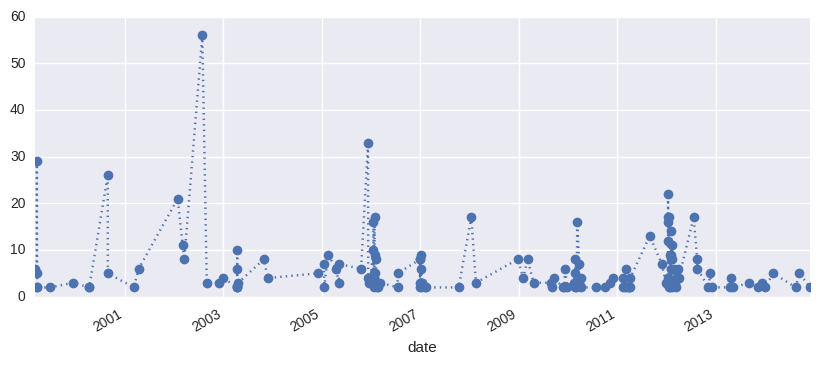

In [18]:
totals_TS = dfs.groupby(by='date')['total'].sum()
totals_TS.plot(style='o:',figsize=(10,4))